In [12]:
import pandas as pd
from secrets import localhost_db
from sqlalchemy import create_engine
from queries import *

In [11]:
DATABASE_URL = localhost_db
TF_WEIGHTS = {0: 6, 1: 5, 2: 4}
MU_WEIGHTS = {'artist': 4, 'track': 1, 'genre': 6, 'feature': 2}

def get_user_from_code(code):
    try:
        code_parts = code.split('-')
        if len(code_parts) != 3 or code_parts[0] not in ADJECTIVES or code_parts[1] not in NOUNS or not (0 < int(code_parts[2]) < 100):
            return None
        engine = create_engine(DATABASE_URL)
        df_u = pd.read_sql('SELECT user_id FROM "UserProfiles" WHERE code = %(code)s', engine, params={'code': code})
        if len(df_u) != 1:
            return None
        return df_u['user_id'].item()
    except:
        return None

def compare_users(u1, u2):
    # Get data
    engine = create_engine(DATABASE_URL)
    users = pd.read_sql(users2_query, engine, params={'user_ids': (u1, u2)})
    df_a = pd.read_sql(top_artists2_query, engine, params={'user_ids': (u1, u2)})
    df_t = pd.read_sql(top_tracks2_query, engine, params={'user_ids': (u1, u2)})
    df_g = pd.read_sql(top_genres2_query, engine, params={'user_ids': (u1, u2)})
    df_m = df_t.groupby(['user_id', 'timeframe']).mean().reset_index()
    # User 1
    u1_a = df_a.loc[df_a['user_id'] == u1]
    u1_t = df_t.loc[df_t['user_id'] == u1]
    u1_g = df_g.loc[df_g['user_id'] == u1]
    u1_m = df_m.loc[df_m['user_id'] == u1]
    # User 2
    u2_a = df_a.loc[df_a['user_id'] == u2]
    u2_t = df_t.loc[df_t['user_id'] == u2]
    u2_g = df_g.loc[df_g['user_id'] == u2]
    u2_m = df_m.loc[df_m['user_id'] == u2]
    # Initialization
    final_points = 0
    similar_artists = pd.DataFrame()
    similar_tracks = pd.DataFrame()
    similar_genres = pd.DataFrame()
    # Compare
    for timeframe in TF_WEIGHTS.keys():
        tf_points = 0
        # Artist
        df_artist = get_artist_similarity(u1_a, u2_a, timeframe)
        tf_points += MU_WEIGHTS['artist'] * calculate_similarity(df_artist)
        df_artist = df_artist.loc[df_artist['points'] > 0].sort_values(by='points', ascending=False)
        df_artist['rank'] = df_artist.reset_index().index + 1
        similar_artists = similar_artists.append(df_artist)
        # Track
        df_track = get_track_similarity(u1_t, u2_t, timeframe)
        tf_points += MU_WEIGHTS['track'] * calculate_similarity(df_track)
        similar_tracks = similar_tracks.append(df_track.loc[df_track['points'] > 0])
        # Genre
        df_genre = get_genre_similarity(u1_g, u2_g, timeframe)
        tf_points += MU_WEIGHTS['genre'] * calculate_similarity(df_genre)
        similar_genres = similar_genres.append(df_genre.loc[df_genre['points'] > 0])
        # Features
        tf_points += MU_WEIGHTS['feature'] * calculate_feature_similarity(u1_m, u2_m, timeframe)
        # Timeframe overall points
        tf_points /= sum(MU_WEIGHTS.values())
        final_points += TF_WEIGHTS[timeframe] * tf_points
    # Final similarity score
    final_points /= sum(TF_WEIGHTS.values())
    return final_points, users, similar_artists, similar_tracks, similar_genres

def get_similar_users(user_id):
    df_u = pd.read_sql(similar_users_query, engine, params={'user_id': user_id})
    users = [user_id] + df_u['user_id'].tolist()
    df_a = pd.read_sql(top_artists2_query, engine, params={'user_ids': tuple(users)})
    df_t = pd.read_sql(top_tracks2_query, engine, params={'user_ids': tuple(users)})
    df_g = pd.read_sql(top_genres2_query, engine, params={'user_ids': tuple(users)})
    df_m = pd.read_sql(music_features2_query, engine, params={'user_ids': tuple(users)})
    # User
    u1_a = df_a.loc[df_a['user_id'] == user_id]
    u1_t = df_t.loc[df_t['user_id'] == user_id]
    u1_g = df_g.loc[df_g['user_id'] == user_id]
    u1_m = df_m.loc[df_m['user_id'] == user_id]
    dict_list = []
    # For each other user
    for _, row in df_u.iterrows():
        u2 = row['user_id']
        u2_a = df_a.loc[df_a['user_id'] == u2]
        u2_t = df_t.loc[df_t['user_id'] == u2]
        u2_g = df_g.loc[df_g['user_id'] == u2]
        u2_m = df_m.loc[df_m['user_id'] == u2]
        points = 0
        # Compare
        for timeframe in TF_WEIGHTS.keys():
            tf_points = 0
            df_artist = get_artist_similarity(u1_a, u2_a, timeframe)
            tf_points += MU_WEIGHTS['artist'] * calculate_similarity(df_artist)
            df_track = get_track_similarity(u1_t, u2_t, timeframe)
            tf_points += MU_WEIGHTS['track'] * calculate_similarity(df_track)
            df_genre = get_genre_similarity(u1_g, u2_g, timeframe)
            tf_points += MU_WEIGHTS['genre'] * calculate_similarity(df_genre)
            tf_points += MU_WEIGHTS['feature'] * calculate_feature_similarity(u1_m, u2_m)
            tf_points /= sum(MU_WEIGHTS.values())
            points += TF_WEIGHTS[timeframe] * tf_points
        # Final similarity score
        points /= sum(TF_WEIGHTS.values())
        dict_list.append({
            'user_id': u2,
            'display_name': row['display_name'],
            'image_url': row['image_url'],
            'points': points
        })
    return pd.DataFrame.from_dict(dict_list).sort_values(by='points', ascending=False)

def get_similar_artists(df_a):
    engine = create_engine(DATABASE_URL)
    artists = pd.read_sql_query(similar_artists_query, engine, params={'artist_ids': tuple(df_a['artist_id'].tolist())})
    engine.dispose()
    df = df_a.merge(artists, on=['artist_id'])
    return df.sort_values(['timeframe', 'points'], ascending=False)

def get_similar_tracks(df_t):
    engine = create_engine(DATABASE_URL)
    tracks = pd.read_sql_query(similar_tracks_query, engine, params={'track_ids': tuple(df_t['track_id'].tolist())})
    engine.dispose()
    df = df_t.merge(tracks, on=['track_id'])
    return df.sort_values(['timeframe', 'points'], ascending=False)

def get_artist_similarity(u1, u2, timeframe):
    merge_on = ['artist_id', 'timeframe', 'artist', 'genres', 'artist_url', 'artist_image']
    df1 = u1.loc[u1['timeframe'] == timeframe]
    df2 = u2.loc[u2['timeframe'] == timeframe]
    df = df1.merge(df2, on=merge_on, how='outer').fillna(0)
    df['base'] = calculate_points(df[df[['rank_x', 'rank_y']] > 0].min(axis=1))
    df.loc[(df['rank_x'] != 0) & (df['rank_y'] != 0), 'points'] = calculate_points(df[['rank_x', 'rank_y']].max(axis=1))
    df['points'] = df['points'].fillna(0)
    # df = df.rename(columns={'rank_x': u1['user_id'].unique()[0], 'rank_y': u2['user_id'].unique()[0]})
    return df

def get_track_similarity(u1, u2, timeframe):
    audio_features = ['danceability', 'energy', 'loudness', 'acousticness', 'instrumentalness', 'liveness', \
                      'valence', 'tempo']
    merge_on = ['track_id', 'timeframe', 'track', 'artists', 'album', 'track_url', 'album_image'] + audio_features
    df1 = u1.loc[u1['timeframe'] == timeframe]
    df2 = u2.loc[u2['timeframe'] == timeframe]
    df = df1.merge(df2, on=merge_on, how='outer').fillna(0)
    df['base'] = calculate_points(df[df[['rank_x', 'rank_y']] > 0].min(axis=1))
    df.loc[(df['rank_x'] != 0) & (df['rank_y'] != 0), 'points'] = calculate_points(df[['rank_x', 'rank_y']].max(axis=1))
    df['points'] = df['points'].fillna(0)
    # df = df.rename(columns={'rank_x': u1['user_id'].unique()[0], 'rank_y': u2['user_id'].unique()[0]})
    return df

def get_genre_similarity(u1, u2, timeframe):
    df1 = u1.loc[u1['timeframe'] == timeframe]
    df2 = u2.loc[u2['timeframe'] == timeframe]
    df = df1.merge(df2, on=['genre', 'timeframe'], how='outer').fillna(0)
    df['base'] = calculate_points(df[df[['rank_x', 'rank_y']] > 0].min(axis=1))
    df.loc[(df['rank_x'] != 0) & (df['rank_y'] != 0), 'points'] = calculate_points(df[df[['rank_x', 'rank_y']] > 0].max(axis=1))
    df['points'] = df['points'].fillna(0)
    # df = df.rename(columns={'rank_x': u1['user_id'].unique()[0], 'rank_y': u2['user_id'].unique()[0]})
    return df.sort_values(['timeframe', 'points'], ascending=False)

def calculate_similarity(df):
    base_score = df.loc[(df['rank_x'] != 0) & (df['rank_y'] != 0)].sum()['base']
    base_score += df.loc[(df['rank_x'] == 0) | (df['rank_y'] == 0)].sum()['base'] / 2
    return round(df.sum()['points'] / base_score, 4)

def calculate_feature_similarity(u1, u2, timeframe):
    features1 = u1.loc[u1['timeframe'] == timeframe].drop(columns=['user_id', 'timeframe']).values.tolist()[0]
    features2 = u2.loc[u2['timeframe'] == timeframe].drop(columns=['user_id', 'timeframe']).values.tolist()[0]
    points = []
    for i in range(len(features1)):
        f1 = abs(features1[i])
        f2 = abs(features2[i])
        points.append(min(f1, f2) / max(f1, f2))
    return round(sum(points) / len(points), 4)

def calculate_points(rank, weight=16, shift=4):
    return weight / ((0.1 * rank + shift) ** 2) 

In [3]:
u1 = '12120382831'
u2 = '12153521253'

In [13]:
def generate_playlist(u1, u2):
    # Get data from database
    engine = create_engine(DATABASE_URL)
    users = pd.read_sql(users2_query, engine, params={'user_ids': (u1, u2)})
    df_a = pd.read_sql(top_artists2_query, engine, params={'user_ids': (u1, u2)})
    df_t = pd.read_sql(top_tracks2_query, engine, params={'user_ids': (u1, u2)})
    # Similar tracks
    similar_tracks = df_t.loc[df_t.duplicated(subset=['track_id', 'timeframe'])]
    # Split by users
    u1_a = df_a.loc[(df_a['user_id'] == u1) & (df_a['rank'] <= 20)]
    u1_t = all_t.loc[(all_t['user_id'] == u1) & (all_t['rank'] <= 20)]
    u2_a = all_a.loc[(all_a['user_id'] == u2) & (df_a['rank'] <= 20)]
    u2_t = all_t.loc[(all_t['user_id'] == u2) & (all_t['rank'] <= 20)]

In [51]:
df_t['track_id']

41    3ZCTVFBt2Brf31RLEnCkWJ
1     73jVPicY2G9YHmzgjk69ae
Name: track_id, dtype: object

In [124]:
def get_tracks_weight(user_t, other_a):
    dict_list = []
    for _, t in user_t.iterrows():
        weight = 21 - t['rank']
        artist = t['artists'].split(';')[0]
        if other_a['artist'].str.contains(artist).any():
            weight += 26 - other_a.loc[other_a['artist'].str.contains(artist)]['rank'].mean()
        dict_list.append({
            'track_id': t['track_id'],
            'track': t['track'],
            'artists': t['artists'],
            'album': t['album'],
            'track_url': t['track_url'],
            'album_image': t['album_image'],
            'weight': weight
        })
    return dict_list

TOTAL_SONGS = 30

playlist_dicts = get_tracks_weight(u1_t, u2_a)
playlist_dicts.extend(get_tracks_weight(u2_t, u1_a))

df_p = pd.DataFrame.from_dict(playlist_dicts).sort_values(by='weight', ascending=False)
df_p = df_p.loc[~df_p['track_id'].isin(df_t['track_id'])].drop_duplicates(subset=['track_id'])
df_f = df_t.sort_values(by='points').drop_duplicates().rename(columns={'points': 'weight'})
df_f = df_f[['track_id', 'track', 'artists', 'album', 'track_url', 'album_image']]
n_sample = TOTAL_SONGS - len(df_f)
df_f = df_f.append(df_p.sample(weights=df_p['weight'], n=n_sample).sort_values(by='weight', ascending=False))

In [125]:
df_f

,track_id,track,artists,album,track_url,album_image,weight
41,3ZCTVFBt2Brf31RLEnCkWJ,everything i wanted,Billie Eilish,everything i wanted,https://open.spotify.com/track/3ZCTVFBt2Brf31R...,https://i.scdn.co/image/ab67616d0000b273f2248c...,NaN
1,73jVPicY2G9YHmzgjk69ae,Robbers,The 1975,The 1975,https://open.spotify.com/track/73jVPicY2G9YHmz...,https://i.scdn.co/image/ab67616d0000b27304f21e...,NaN
100,1RMJOxR6GRPsBHL8qeC2ux,Best Part (feat. H.E.R.),Daniel Caesar; H.E.R.,Freudian,https://open.spotify.com/track/1RMJOxR6GRPsBHL...,https://i.scdn.co/image/ab67616d0000b2733138f8...,43.000000
109,7zFXmv6vqI4qOt4yGf3jYZ,Get You (feat. Kali Uchis),Daniel Caesar; Kali Uchis,Freudian,https://open.spotify.com/track/7zFXmv6vqI4qOt4...,https://i.scdn.co/image/ab67616d0000b2733138f8...,34.000000
23,7vgTNTaEz3CsBZ1N4YQalM,Ghost Town,Kanye West; PARTYNEXTDOOR,ye,https://open.spotify.com/track/7vgTNTaEz3CsBZ1...,https://i.scdn.co/image/ab67616d0000b2730cd942...,31.500000
9,19YKaevk2bce4odJkP5L22,Nikes,Frank Ocean,Blonde,https://open.spotify.com/track/19YKaevk2bce4od...,https://i.scdn.co/image/ab67616d0000b273c5649a...,30.666667
31,6Vigp41BietH0WoFZ52JI5,All We Do,Oh Wonder,Oh Wonder,https://open.spotify.com/track/6Vigp41BietH0Wo...,https://i.scdn.co/image/ab67616d0000b2737cc94e...,29.500000
12,0KyzXQhY2yzcb1FYCHkZc2,Blessed,Daniel Caesar,Freudian,https://open.spotify.com/track/0KyzXQhY2yzcb1F...,https://i.scdn.co/image/ab67616d0000b2733138f8...,29.000000
6,0yc6Gst2xkRu0eMLeRMGCX,Apocalypse,Cigarettes After Sex,Cigarettes After Sex,https://open.spotify.com/track/0yc6Gst2xkRu0eM...,https://i.scdn.co/image/ab67616d0000b27394d280...,29.000000
8,0NlGoUyOJSuSHmngoibVAs,All I Want,Kodaline,In A Perfect World (Expanded Edition),https://open.spotify.com/track/0NlGoUyOJSuSHmn...,https://i.scdn.co/image/ab67616d0000b2733e4285...,28.500000


In [80]:
x = df_f['album_image'].iloc[0]
x

'https://i.scdn.co/image/ab67616d0000b273f2248cf6dad1d6c062587249'

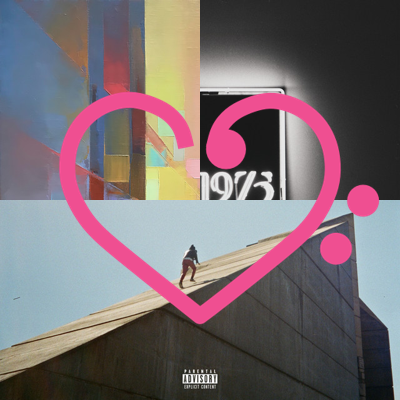

In [133]:
from PIL import Image
import requests
from io import BytesIO

p_img = Image.new('RGB', (400, 400))
for i in range(4):
    this_url = df_f['album_image'].iloc[i]
    img = Image.open(requests.get(this_url, stream=True).raw)
    img.thumbnail((400, 400))
    if i == 0:
        p_img.paste(img.crop((0, 0, 200, 200)), (0, 0))
    elif i == 1:
        p_img.paste(img.crop((200, 0, 400, 200)), (200, 0))
    elif i == 2:
        p_img.paste(img.crop((0, 200, 200, 400)), (0, 200))
    else:
        p_img.paste(img.crop((200, 200, 400, 400)), (200, 200))

img = Image.open('rect1822.png')
img.thumbnail((400, 400))
p_img.paste(img, (0, 0), img)
p_img

In [135]:
import spotipy
from secrets import spotify_secrets
from spotipy.oauth2 import SpotifyOAuth

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=spotify_secrets["Client Id"],
                                               client_secret=spotify_secrets["Client Secret"],
                                               redirect_uri="http://localhost:8892/callback",
                                               scope="playlist-modify-public ugc-image-upload"))

In [118]:
sp.user_playlist_create(u1, 'Test', public=True, collaborative=False, description='Created by Soundbud')

{'collaborative': False,
 'description': 'Created by Soundbud',
 'external_urls': {'spotify': 'https://open.spotify.com/playlist/0bF7Fwe2UJNV7g9ZHPTBNt'},
 'followers': {'href': None, 'total': 0},
 'href': 'https://api.spotify.com/v1/playlists/0bF7Fwe2UJNV7g9ZHPTBNt',
 'id': '0bF7Fwe2UJNV7g9ZHPTBNt',
 'images': [],
 'name': 'Test',
 'owner': {'display_name': 'Bin Xuan Kong',
  'external_urls': {'spotify': 'https://open.spotify.com/user/12120382831'},
  'href': 'https://api.spotify.com/v1/users/12120382831',
  'id': '12120382831',
  'type': 'user',
  'uri': 'spotify:user:12120382831'},
 'primary_color': None,
 'public': True,
 'snapshot_id': 'MSxhMDhlZDM0Njg3ZDE5NzBlOTdhMzBhMzM4YzcyOTFjMWNjYjQ3MTYz',
 'tracks': {'href': 'https://api.spotify.com/v1/playlists/0bF7Fwe2UJNV7g9ZHPTBNt/tracks',
  'items': [],
  'limit': 100,
  'next': None,
  'offset': 0,
  'previous': None,
  'total': 0},
 'type': 'playlist',
 'uri': 'spotify:playlist:0bF7Fwe2UJNV7g9ZHPTBNt'}

In [119]:
playlist_id = '0bF7Fwe2UJNV7g9ZHPTBNt'

In [127]:
track_ids = df_f['track_id']
len(track_ids)

30

In [129]:
sp.user_playlist_add_tracks(u1, playlist_id, track_ids)

{'snapshot_id': 'OCwxMGU4MDUxMGU5NzgwMTI2MTRlOWYzMGNkY2M0OGIzZmE3OWFiNzgx'}

In [136]:
import base64

buffered = BytesIO()
p_img.save(buffered, format="JPEG")
img_str = base64.b64encode(buffered.getvalue())

sp.playlist_upload_cover_image(playlist_id, img_str)

In [51]:
df_t['track_id']

41    3ZCTVFBt2Brf31RLEnCkWJ
1     73jVPicY2G9YHmzgjk69ae
Name: track_id, dtype: object